In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from openpyxl import load_workbook
from numba import jit

In [ ]:
# Define the boundary and well radius
l = 4.0
r_out = 0.9
r_in = 0.1 + (r_out-0.9)     #well radius
b = r_out
depth=0          #depth=0:original Try different depth values
w_h = 1.5+depth   #well height
cap = 2.3+depth   #cap height
eff_dep = 0.5   #position of effective depth of well
fps=30
# Define the diffusion coefficient and beta value
r_bead = 0.1
D_0 = 1.005
r_0 = 0.1
k = D_0*r_0
D = k/r_bead
beta = 3.0

# Define the step size and the total simulation time
dx = dy = dz = 0.04

# Choose the excel file to save data
path = "./Excel/"+str(D)+'_'+str(fps)+'Hz_depth='+str(depth)+'Hz_step_size='+str(dx)+'_angle_rim.xlsx'
print(path)


./Excel/1.005_1000Hz_depth=0Hz_step_size=0.04_angle_rim.xlsx


0.12962962962962965


Text(0.5, 1.0, 'Geometric well')

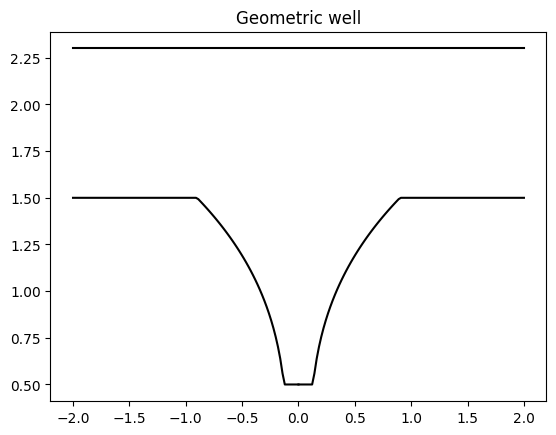

In [17]:
import warnings
# Well
eff_r_in = (r_out-r_in)*((((eff_dep-w_h)/w_h)+1)**3)+r_in
print(eff_r_in)
@jit(nopython=True)
def well_z(r):
    #warnings.filterwarnings("ignore")
    return (r > r_out)*w_h \
          +(r > eff_r_in)*(r <= r_out)*np.nan_to_num(-w_h*(1-((r-r_in)/(r_out-r_in))**(1/3))+w_h)\
          +(r <= eff_r_in)*eff_dep
@jit(nopython=True)
def well_r(z_pos):
    return (r_out-r_in)*((((z_pos-w_h)/w_h)+1)**3)+r_in
"""
@jit(nopython=True)
def well_z(r):
    #warnings.filterwarnings("ignore")
    return w_h*np.ones_like(r)
@jit(nopython=True)
def well_r(z_pos):
    return r_out
    """
r_span= np.linspace(0, l//2, 100)
z_span= np.linspace(eff_dep, w_h, 100)
plt.plot(r_span,well_z(r_span),color="black")
plt.plot(-r_span,well_z(r_span),color="black")
plt.plot([-l//2,l//2],[cap,cap],color="black")
plt.title("Geometric well")
#plt.plot(z_span,well_r(z_span))

Maximum dwell time at log10(t) = -0.8894618072532053


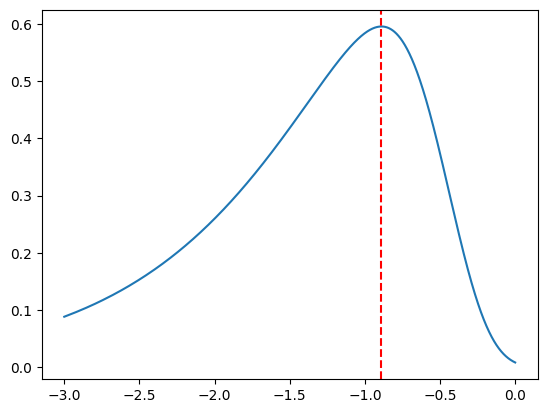

In [4]:
from scipy.special import jn_zeros
n=100
jn_zero = jn_zeros(0, n)
def dwell(t):
    return 4*np.sum(np.exp(-jn_zero[None,:]**2*t[:,None]),axis=1)
unit= r_out**2/D
t=np.linspace(0.001, 1, 10000)
x=np.log10(t)
y=dwell(t/unit)/unit*t*np.log(10)
x_max=x[np.argmax(y)]
print("Maximum dwell time at log10(t) =", x_max)
plt.plot(x,y , label="Dwell time")
plt.axvline(x_max, color='red', linestyle='--', label='Max dwell time')

In [ ]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_wander(L_max=10**3):
    #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6

    # Define the initial state of the nanoparticle
    x = 1.2
    y = 0.4
    z = 1.0
    t = 0.0
    radius = np.sqrt(x**2+y**2)
    #x_track[0],y_track[0],z_track[0],t_track[0]=x,y,z,t

    # IN = 1, OUT = 0
    if radius<=0.9:
        prev_in_well=1
    else:
        prev_in_well=0
    dwell_track=np.zeros((L_max))
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        
        # IN = 1, OUT = 0
        if radius <= 0.9:
            if prev_in_well==0:
                L+=1
                enter_track[L]=shift(np.array([avg_x,avg_y]))
            dwell_track[L]+=1/fps
            prev_in_well=1
        else:
            if prev_in_well==1:
                leave_track[L]=shift(np.array([avg_x,avg_y]))
                angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            prev_in_well=0
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_wander(L_max=10**6)
end_time=time.time()
print(end_time-start_time)



2.2006843090057373


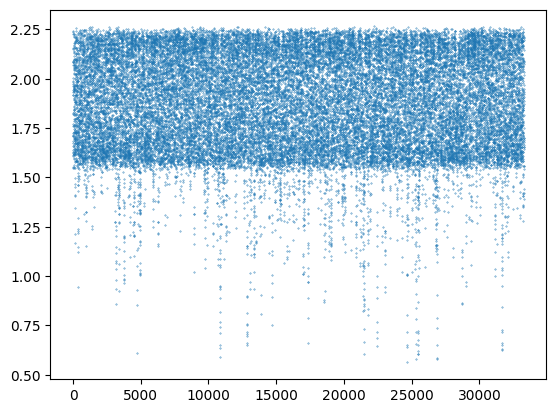

In [6]:
plt.scatter(np.arange(len(z)),z,s=0.1)

Vanilla Gillipise:57.21725916862488

Jit python Gillispie:3.4

10**3: 3.4

10**4:9.3

10**5: 31.87

10**6: 10 min

In [6]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_restart(L_max=10**3):
    #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6
    # Define the initial state of the nanoparticle
    r=np.random.uniform(low=0.0, high=r_out)
    theta=np.random.uniform(low=0.0, high=2*np.pi)
    z_min= well_z(r)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.random.uniform(low=z_min, high=cap)
    t = 0.0
    dwell_track=np.zeros(L_max)
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        if radius <= 0.9:
            dwell_track[L]+=1/fps
        else:
            L+=1
            leave_track[L]=shift(np.array([avg_x,avg_y]))
            angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            r=np.random.uniform(low=0.0, high=r_out)
            theta=np.random.uniform(low=0.0, high=2*np.pi)
            z_min= well_z(r)
            x = r*np.cos(theta)
            y = r*np.sin(theta)
            z = np.random.uniform(low=z_min, high=cap)
            enter_track[L]=shift(np.array([x,y]))
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_restart(L_max=10**6)
end_time=time.time()
print(end_time-start_time)



912.4440407752991


In [33]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_rim(L_max=10**3):
   #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6
    # Define the initial state of the nanoparticle
    r=r_out
    theta=np.random.uniform(low=0.0, high=2*np.pi)
    z_min= well_z(r)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.random.uniform(low=z_min, high=cap)
    t = 0.0
    dwell_track=np.zeros(L_max)
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        if radius <= 0.9:
            dwell_track[L]+=1/fps
        else:
            L+=1
            leave_track[L]=shift(np.array([avg_x,avg_y]))
            angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            r=r_out
            theta=np.random.uniform(low=0.0, high=2*np.pi)
            z_min= well_z(r)
            x = r*np.cos(theta)
            y = r*np.sin(theta)
            z = np.random.uniform(low=z_min, high=cap)
            enter_track[L]=shift(np.array([x,y]))
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_rim(L_max=10**6)
end_time=time.time()
print(end_time-start_time)



113.7643928527832


In [5]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_rim_epsilon(L_max=10**3):
   #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6
    # Define the initial state of the nanoparticle
    r=np.random.uniform(low=r_out-np.sqrt(2)*dx, high=r_out)
    theta=np.random.uniform(low=0.0, high=2*np.pi)
    z_min= well_z(r)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.random.uniform(low=z_min, high=cap)
    t = 0.0
    dwell_track=np.zeros(L_max)
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        if radius <= 0.9:
            dwell_track[L]+=1/fps
        else:
            L+=1
            leave_track[L]=shift(np.array([avg_x,avg_y]))
            angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            r=np.random.uniform(low=r_out-np.sqrt(2)*dx, high=r_out)
            theta=np.random.uniform(low=0.0, high=2*np.pi)
            z_min= well_z(r)
            x = r*np.cos(theta)
            y = r*np.sin(theta)
            z = np.random.uniform(low=z_min, high=cap)
            enter_track[L]=shift(np.array([x,y]))
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_rim_epsilon(L_max=10**6)
end_time=time.time()
print(end_time-start_time)



183.8237602710724


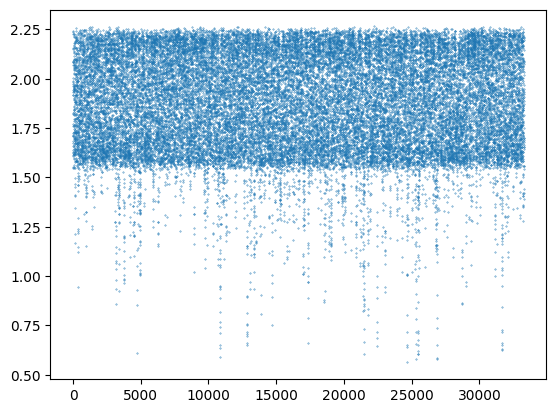

In [10]:
plt.scatter(np.arange(len(z)),z,s=0.1)

In [5]:
import numpy as np
import pandas as pd
from openpyxl import load_workbook

In [37]:
print(angle_track.shape)
#print(leave_track)

(1000000,)


In [6]:
with pd.ExcelWriter(path, engine='openpyxl') as writer:
	d = {'dwell_time': dwell_track[1:-1],"angle":angle_track[1:-1]}
	df = pd.DataFrame(data = d)
	df.to_excel(writer, index = True, sheet_name = 'dwell time')
	

In [39]:
"""
import plotly.express as px
import plotly.graph_objects as go

fig =go.Figure(data=px.scatter_3d(df, x='x', y='y', z='z',color='t'))
x_scale=np.max(df['x'])-np.min(df['x'])
y_scale=np.max(df['y'])-np.min(df['y'])
Max=max(x_scale,y_scale)
fig.update_traces(marker_size = 3)
fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        aspectratio = dict( x=x_scale*0.9/Max, y=y_scale/Max, z=0.7),
        aspectmode = 'manual'
    ),
)
#for i in range(-2,2):
    #for j in range(-4,1):
        #fig.add_trace(go.Surface(z=Z, x=x+i*l, y=y+j*l, opacity=0.5, colorscale='Blues'))
fig.show()
"""

"\nimport plotly.express as px\nimport plotly.graph_objects as go\n\nfig =go.Figure(data=px.scatter_3d(df, x='x', y='y', z='z',color='t'))\nx_scale=np.max(df['x'])-np.min(df['x'])\ny_scale=np.max(df['y'])-np.min(df['y'])\nMax=max(x_scale,y_scale)\nfig.update_traces(marker_size = 3)\nfig.update_layout(\n    width=800,\n    height=700,\n    autosize=False,\n    scene=dict(\n        aspectratio = dict( x=x_scale*0.9/Max, y=y_scale/Max, z=0.7),\n        aspectmode = 'manual'\n    ),\n)\n#for i in range(-2,2):\n    #for j in range(-4,1):\n        #fig.add_trace(go.Surface(z=Z, x=x+i*l, y=y+j*l, opacity=0.5, colorscale='Blues'))\nfig.show()\n"

In [10]:
path0= './Excel/1.005_30Hz_step_size=0.04_angle_restart.xlsx'
data0 = pd.read_excel(path0, sheet_name='dwell time')
path1= './Excel/1.005_1000Hz_step_size=0.04_angle_restart.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')

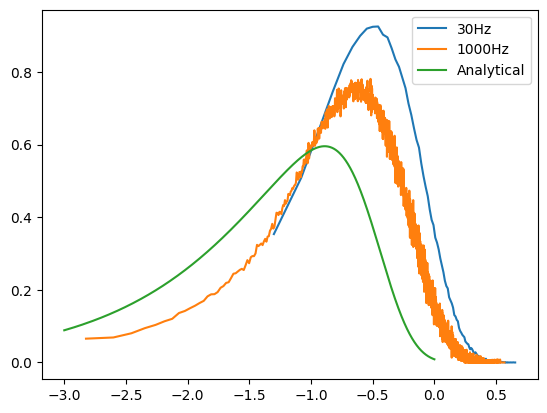

In [11]:
Time0=data0['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge0=np.arange(1/30,np.max(Time0),1/30)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2
Time1=data1['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge1=np.arange(1/1000,np.max(Time1),1/1000)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
accuracy=6
hist0,bin1= np.histogram(np.round(Time0,decimals=accuracy), bins =np.round(bin_edge0,decimals=accuracy),density=True)
hist1,bin1= np.histogram(np.round(Time1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
plt.plot(np.log10(bin_center0),bin_center0*hist0*np.log(10),label='30Hz')
plt.plot(np.log10(bin_center1),bin_center1*hist1*np.log(10),label='1000Hz')
unit= r_out**2/D
t=np.linspace(0.001, 1, 10000)
x=np.log10(t)
y=dwell(t/unit)/unit*t*np.log(10)
plt.plot(x,y , label="Analytical")
plt.legend()


In [43]:
path0= './Excel/1.005_30Hz_step_size=0.04_angle_rim.xlsx'
data0 = pd.read_excel(path0, sheet_name='dwell time')
path1= './Excel/1.005_30Hz_step_size=0.04_angle_wander.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
path2= './Excel/1.005_30Hz_step_size=0.04_angle_rim_epsilon.xlsx'
data2 = pd.read_excel(path2, sheet_name='dwell time')

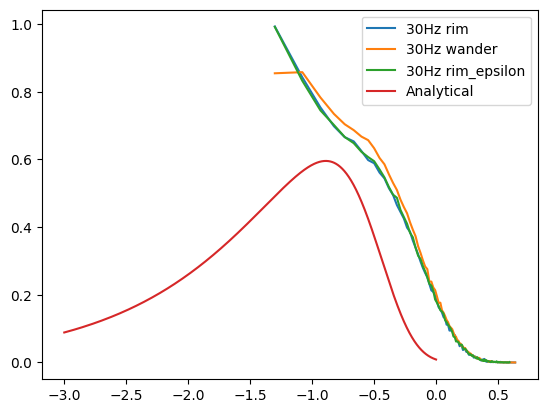

In [44]:
Time0=data0['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge0=np.arange(1/30,np.max(Time0),1/30)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2
Time1=data1['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time2=data2['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge2=np.arange(1/30,np.max(Time2),1/30)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
accuracy=6
hist0,bin1= np.histogram(np.round(Time0,decimals=accuracy), bins =np.round(bin_edge0,decimals=accuracy),density=True)
hist1,bin1= np.histogram(np.round(Time1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
hist2,bin1= np.histogram(np.round(Time2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy),density=True)
plt.plot(np.log10(bin_center0),bin_center0*hist0*np.log(10),label='30Hz rim')
plt.plot(np.log10(bin_center1),bin_center1*hist1*np.log(10),label='30Hz wander')
plt.plot(np.log10(bin_center2),bin_center2*hist2*np.log(10),label='30Hz rim_epsilon')
unit= r_out**2/D
t=np.linspace(0.001, 1, 10000)
x=np.log10(t)
y=dwell(t/unit)/unit*t*np.log(10)
plt.plot(x,y , label="Analytical")
plt.legend()


In [9]:
path0= './Excel/1.005_1000Hz_step_size=0.04_angle_rim.xlsx'
data0 = pd.read_excel(path0, sheet_name='dwell time')
path1= './Excel/1.005_1000Hz_step_size=0.04_angle_wander.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
path2= './Excel/1.005_1000Hz_step_size=0.04_angle_rim_epsilon.xlsx'
data2 = pd.read_excel(path2, sheet_name='dwell time')

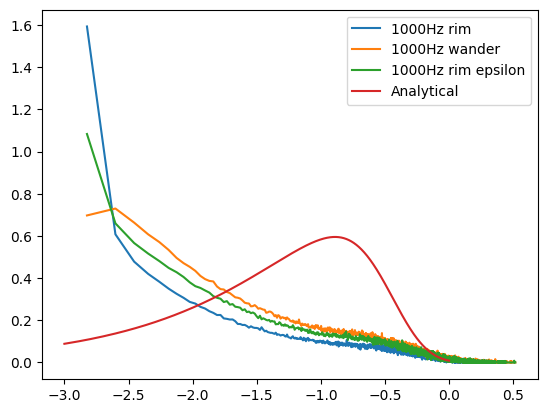

In [10]:
Time0=data0['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge0=np.arange(1/1000,np.max(Time0),1/1000)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2
Time1=data1['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge1=np.arange(1/1000,np.max(Time1),1/1000)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time2=data2['dwell_time']
#angle0=data0['angle']
#angle_0=Time0[angle0<=np.pi]
bin_edge2=np.arange(1/1000,np.max(Time1),1/1000)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
accuracy=6
hist0,bin1= np.histogram(np.round(Time0,decimals=accuracy), bins =np.round(bin_edge0,decimals=accuracy),density=True)
hist1,bin1= np.histogram(np.round(Time1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
hist2,bin1= np.histogram(np.round(Time2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy),density=True)
plt.plot(np.log10(bin_center0),bin_center0*hist0*np.log(10),label='1000Hz rim')
plt.plot(np.log10(bin_center1),bin_center1*hist1*np.log(10),label='1000Hz wander')
plt.plot(np.log10(bin_center2),bin_center2*hist2*np.log(10),label='1000Hz rim epsilon')
unit= r_out**2/D
t=np.linspace(0.001, 1, 10000)
x=np.log10(t)
y=dwell(t/unit)/unit*t*np.log(10)
plt.plot(x,y , label="Analytical")
plt.legend()


In [12]:
path0= './Excel/1.005_30Hz_step_size=0.04_angle_wander.xlsx'
data0 = pd.read_excel(path0, sheet_name='dwell time')

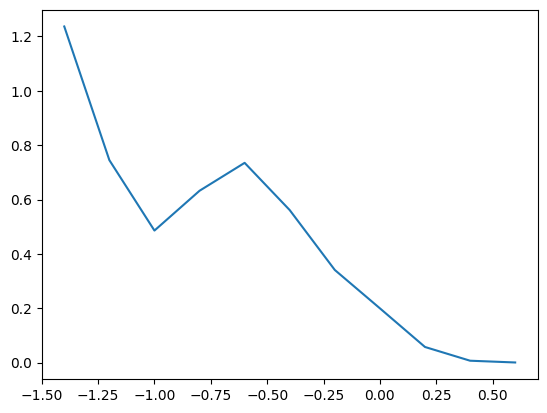

In [13]:
bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time=data0['dwell_time']
hist1,bin1= np.histogram(np.log10(Time), bins = bin_edge1,density=True)
plt.plot(bin_center1,hist1)